### Import libraries and datasets:

In [95]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional

In [96]:
csv_fts = "D:\\HK2 (NĂM 3)\\RIGHTNOW\\FTS Historical Data.csv"
csv_mwg = "D:\\HK2 (NĂM 3)\\RIGHTNOW\\MWG Historical Data.csv"
csv_vic = "D:\\HK2 (NĂM 3)\\RIGHTNOW\\VIC Historical Data.csv"



df_fts = pd.read_csv(csv_fts, thousands=',')
df_mwg = pd.read_csv(csv_mwg, thousands=',')
df_vic = pd.read_csv(csv_vic, thousands=',')

### Dataset 1: FTS

- Cast Date column to datetime type
- Sort data ascending by Date

In [97]:
df_fts['Date'] = pd.to_datetime(df_fts['Date'])
df_fts = df_fts.sort_values(by='Date', ascending=True)
df_fts.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,5788.4,5859.2,5859.2,5788.4,103.55K,-1.21%
1358,2018-01-03,5953.7,5764.7,5977.4,5741.1,245.02K,2.86%
1357,2018-01-04,6024.6,5953.7,6142.8,5906.5,167.80K,1.19%
1356,2018-01-05,5882.9,5977.4,6048.2,5882.9,113.88K,-2.35%
1355,2018-01-08,6001.0,5859.2,6001.0,5764.7,63.36K,2.01%


- Split Price data
- Reset index

In [98]:
df_price = df_fts[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,5788.4
1,5953.7
2,6024.6
3,5882.9
4,6001.0


- Scale data between 0 and 1:

In [99]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.000000
1,0.003587
2,0.005125
3,0.002051
4,0.004613


- Split data into train, test, val (7 - 2 - 1):

In [100]:
train_size = int(0.8 * len(df_price))
test_size = int(0.1 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1088, 1)
(136, 1)
(136, 1)


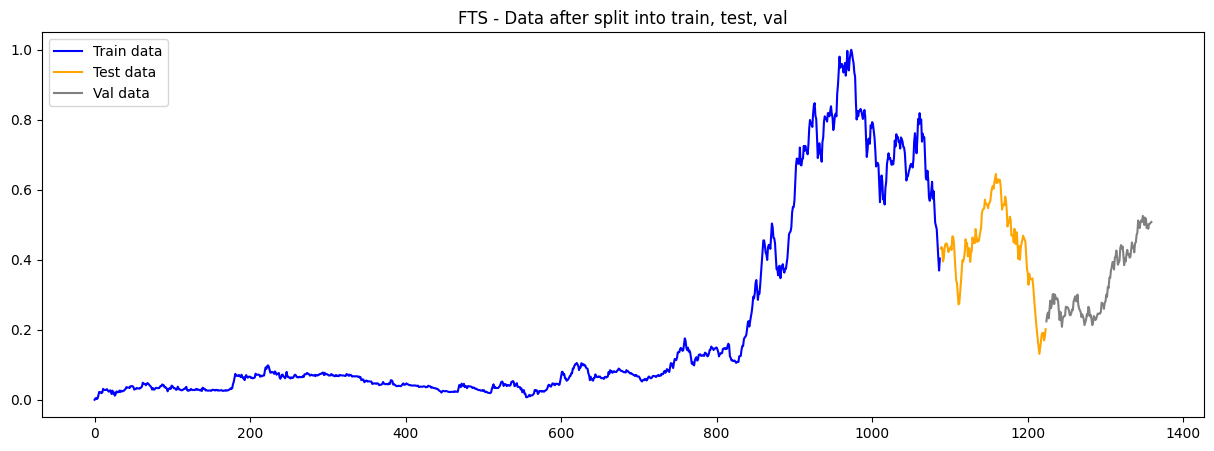

In [101]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('FTS - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [102]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)] 
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [103]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Reshape data:

In [104]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

- Model training:

In [105]:
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1))))
model_bilstm.add(Bidirectional(LSTM(25, return_sequences=True)))
model_bilstm.add(Bidirectional(LSTM(25)))
model_bilstm.add(Dense(1))
model_bilstm.compile(loss='mean_squared_error',optimizer='adam')

In [106]:
model_bilstm.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100


17/17 [==============================] - 14s 171ms/step - loss: 0.0222 - val_loss: 0.0109
Epoch 2/100
17/17 [==============================] - 1s 43ms/step - loss: 0.0041 - val_loss: 0.0103
Epoch 3/100
17/17 [==============================] - 1s 43ms/step - loss: 0.0030 - val_loss: 0.0098
Epoch 4/100
17/17 [==============================] - 1s 55ms/step - loss: 0.0026 - val_loss: 0.0098
Epoch 5/100
17/17 [==============================] - 1s 46ms/step - loss: 0.0021 - val_loss: 0.0113
Epoch 6/100
17/17 [==============================] - 1s 59ms/step - loss: 0.0018 - val_loss: 0.0125
Epoch 7/100
17/17 [==============================] - 1s 62ms/step - loss: 0.0015 - val_loss: 0.0054
Epoch 8/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 9/100
17/17 [==============================] - 1s 55ms/step - loss: 0.0010 - val_loss: 0.0040
Epoch 10/100
17/17 [==============================] - 1s 46ms/step - loss: 0.0014 - val_loss: 0.0089
Epoch 11/

- Model Prediction on test, val (one-step prediction):

In [107]:
y_pred_test = model_bilstm.predict(x_test)
y_pred_val = model_bilstm.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

4/4 [==============================] - 0s 12ms/step


- 30 days prediction:

In [108]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags, 1)
    y_hat = model_bilstm.predict(x_input, verbose=0)
    temp_input.extend(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.extend(y_hat[0])
    i += 1


In [109]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[25401.238],
       [25716.316],
       [26076.213],
       [26483.17 ],
       [26923.324],
       [27400.709],
       [27901.467],
       [28427.959],
       [28968.916],
       [29521.928],
       [30080.527],
       [30644.883],
       [31217.633],
       [31781.414],
       [32340.625],
       [32890.74 ],
       [33441.6  ],
       [33994.406],
       [34541.344],
       [35079.887],
       [35597.555],
       [36097.883],
       [36584.9  ],
       [37055.582],
       [37520.746],
       [37985.367],
       [38438.527],
       [38889.03 ],
       [39329.42 ],
       [39762.25 ]], dtype=float32)

- Model evaluating (RMSE - MAPE - MSLE):

In [110]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 27760.2799
Validating RMSE: 22992.3867
Predicting 30 days RMSE: 32845.1594

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 96.3079
Validating MSLE: 94.1641
Predicting 30 days MSLE: 99.8074


- Prediction plotting:

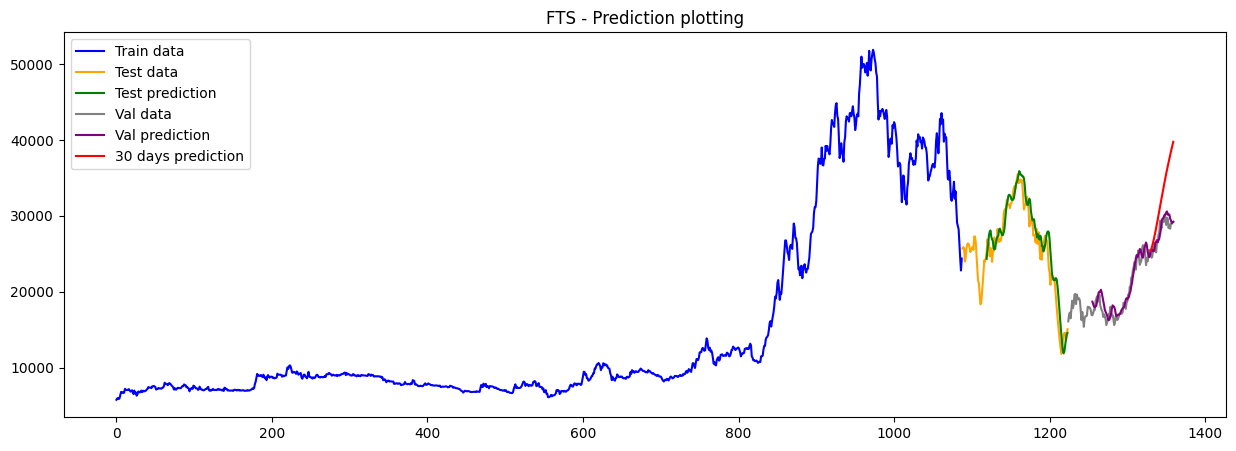

In [111]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('FTS - Prediction plotting')
plt.show()

### Dataset 2: MWG

In [112]:
df_mwg['Date'] = pd.to_datetime(df_mwg['Date'])
df_mwg = df_mwg.sort_values(by='Date', ascending=True)
df_mwg.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,31276,31039,31394,31039,2.27M,0.76%
1358,2018-01-03,31892,31323,32034,31276,4.53M,1.97%
1357,2018-01-04,31963,31773,32081,31750,2.71M,0.22%
1356,2018-01-05,31608,31987,31987,31465,2.93M,-1.11%
1355,2018-01-08,31110,31394,31513,31039,3.01M,-1.58%


- Split Price data
- Reset index

In [113]:
df_price = df_mwg[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,31276
1,31892
2,31963
3,31608
4,31110


- Scale data between 0 and 1:

In [114]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.200020
1,0.210221
2,0.211397
3,0.205518
4,0.197271


- Split data into train, test, val (7 - 2 - 1):

In [115]:
train_size = int(0.8 * len(df_price))
test_size = int(0.1 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1088, 1)
(136, 1)
(136, 1)


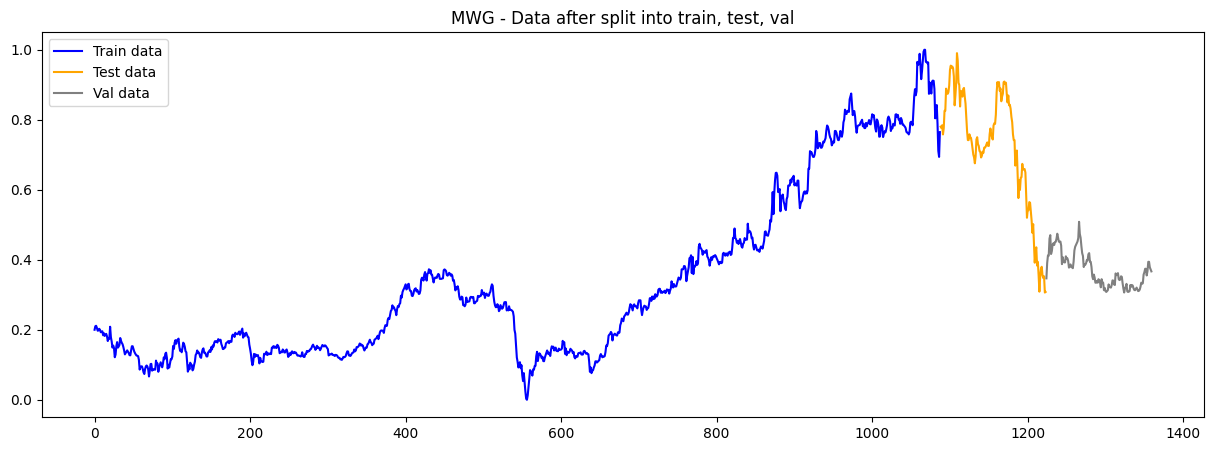

In [116]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('MWG - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [117]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)] 
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [118]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Reshape data:

In [119]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

- Model training:

In [120]:
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1))))
model_bilstm.add(Bidirectional(LSTM(25, return_sequences=True)))
model_bilstm.add(Bidirectional(LSTM(25)))
model_bilstm.add(Dense(1))
model_bilstm.compile(loss='mean_squared_error',optimizer='adam')

In [121]:
model_bilstm.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100


17/17 [==============================] - 16s 180ms/step - loss: 0.0236 - val_loss: 0.0208
Epoch 2/100
17/17 [==============================] - 1s 41ms/step - loss: 0.0036 - val_loss: 0.0137
Epoch 3/100
17/17 [==============================] - 1s 41ms/step - loss: 0.0022 - val_loss: 0.0147
Epoch 4/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0019 - val_loss: 0.0169
Epoch 5/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0017 - val_loss: 0.0151
Epoch 6/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0016 - val_loss: 0.0156
Epoch 7/100
17/17 [==============================] - 1s 42ms/step - loss: 0.0015 - val_loss: 0.0153
Epoch 8/100
17/17 [==============================] - 1s 45ms/step - loss: 0.0014 - val_loss: 0.0160
Epoch 9/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0014 - val_loss: 0.0120
Epoch 10/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0013 - val_loss: 0.0133
Epoch 11/

- Model Prediction on test, val (one-step prediction):

In [122]:
y_pred_test = model_bilstm.predict(x_test)
y_pred_val = model_bilstm.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

4/4 [==============================] - 0s 12ms/step


- 30 days prediction:

In [123]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags, 1)
    y_hat = model_bilstm.predict(x_input, verbose=0)
    temp_input.extend(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.extend(y_hat[0])
    i += 1


In [124]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[37819.453],
       [37650.246],
       [37491.7  ],
       [37341.64 ],
       [37200.24 ],
       [37063.53 ],
       [36943.793],
       [36839.527],
       [36750.164],
       [36671.574],
       [36601.797],
       [36547.09 ],
       [36509.05 ],
       [36478.637],
       [36439.047],
       [36405.797],
       [36374.688],
       [36343.8  ],
       [36321.2  ],
       [36298.137],
       [36271.477],
       [36238.863],
       [36207.348],
       [36185.098],
       [36169.715],
       [36156.926],
       [36135.055],
       [36106.875],
       [36071.77 ],
       [36042.56 ]], dtype=float32)

- Model evaluating (RMSE - MAPE - MSLE):

In [125]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 62469.1167
Validating RMSE: 41055.4127
Predicting 30 days RMSE: 36592.1122

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 110.3524
Validating MSLE: 106.3677
Predicting 30 days MSLE: 104.3566


- Prediction plotting:

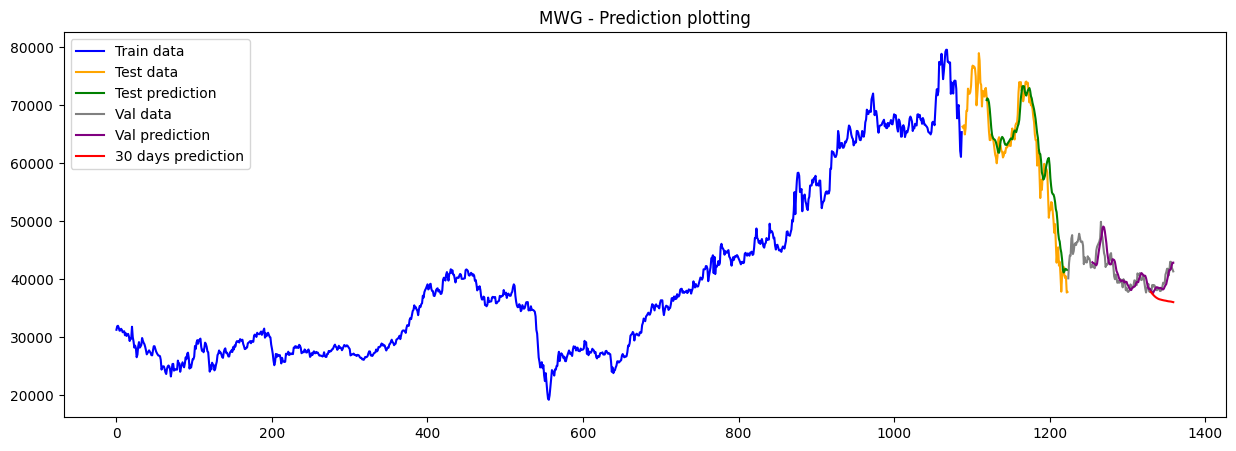

In [126]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('MWG - Prediction plotting')
plt.show()

- Prediction plotting:

### Dataset 3: VIC

In [127]:
df_vic['Date'] = pd.to_datetime(df_vic['Date'])
df_vic = df_vic.sort_values(by='Date', ascending=True)
df_vic.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,64628,64132,64876,63967,1.74M,1.16%
1358,2018-01-03,66529,65702,68760,64959,6.07M,2.94%
1357,2018-01-04,66942,67355,68678,66529,3.55M,0.62%
1356,2018-01-05,66116,66942,66942,65289,3.42M,-1.23%
1355,2018-01-08,66364,66116,67686,65372,4.81M,0.38%


- Split Price data
- Reset index

In [128]:
df_price = df_vic[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,64628
1,66529
2,66942
3,66116
4,66364


- Scale data between 0 and 1:

In [129]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.182297
1,0.206826
2,0.212155
3,0.201497
4,0.204697


- Split data into train, test, val (7 - 2 - 1):

In [130]:
train_size = int(0.8 * len(df_price))
test_size = int(0.1 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1088, 1)
(136, 1)
(136, 1)


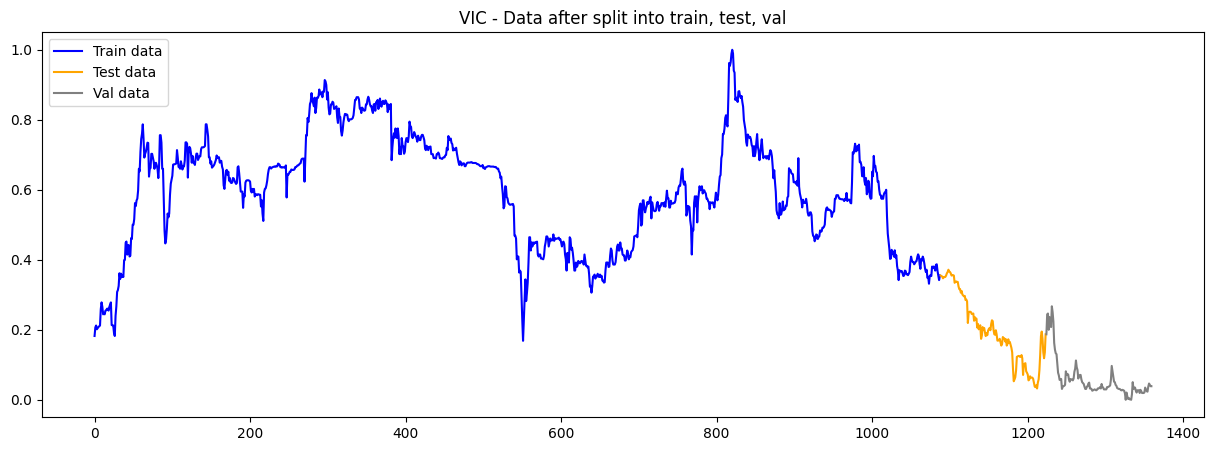

In [131]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('VIC - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [132]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)] 
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [133]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Reshape data:

In [134]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

- Model training:

In [135]:
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1))))
model_bilstm.add(Bidirectional(LSTM(25, return_sequences=True)))
model_bilstm.add(Bidirectional(LSTM(25)))
model_bilstm.add(Dense(1))
model_bilstm.compile(loss='mean_squared_error',optimizer='adam')

In [136]:
model_bilstm.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100


17/17 [==============================] - 14s 179ms/step - loss: 0.0688 - val_loss: 0.0108
Epoch 2/100
17/17 [==============================] - 1s 48ms/step - loss: 0.0119 - val_loss: 0.0302
Epoch 3/100
17/17 [==============================] - 1s 48ms/step - loss: 0.0072 - val_loss: 0.0281
Epoch 4/100
17/17 [==============================] - 1s 46ms/step - loss: 0.0065 - val_loss: 0.0196
Epoch 5/100
17/17 [==============================] - 1s 41ms/step - loss: 0.0057 - val_loss: 0.0138
Epoch 6/100
17/17 [==============================] - 1s 43ms/step - loss: 0.0048 - val_loss: 0.0087
Epoch 7/100
17/17 [==============================] - 1s 42ms/step - loss: 0.0042 - val_loss: 0.0053
Epoch 8/100
17/17 [==============================] - 1s 41ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 9/100
17/17 [==============================] - 1s 43ms/step - loss: 0.0031 - val_loss: 0.0061
Epoch 10/100
17/17 [==============================] - 1s 42ms/step - loss: 0.0029 - val_loss: 0.0058
Epoch 11/

- Model Prediction on test, val (one-step prediction):

In [137]:
y_pred_test = model_bilstm.predict(x_test)
y_pred_val = model_bilstm.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

4/4 [==============================] - 0s 11ms/step


- 30 days prediction:

In [138]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags, 1)
    y_hat = model_bilstm.predict(x_input, verbose=0)
    temp_input.extend(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.extend(y_hat[0])
    i += 1


In [139]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[51237.742],
       [51114.84 ],
       [50998.848],
       [50886.61 ],
       [50773.047],
       [50656.938],
       [50538.152],
       [50418.355],
       [50304.004],
       [50203.29 ],
       [50100.14 ],
       [49993.297],
       [49883.125],
       [49772.5  ],
       [49659.184],
       [49544.316],
       [49426.63 ],
       [49307.605],
       [49187.445],
       [49066.777],
       [48945.504],
       [48823.56 ],
       [48701.992],
       [48581.41 ],
       [48461.11 ],
       [48340.785],
       [48218.156],
       [48090.08 ],
       [47967.312],
       [47841.375]], dtype=float32)

- Model evaluating (RMSE - MAPE - MSLE):

In [140]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 63871.0493
Validating RMSE: 53360.1448
Predicting 30 days RMSE: 49578.2849

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 119.0622
Validating MSLE: 117.6564
Predicting 30 days MSLE: 116.3318


- Prediction plotting:

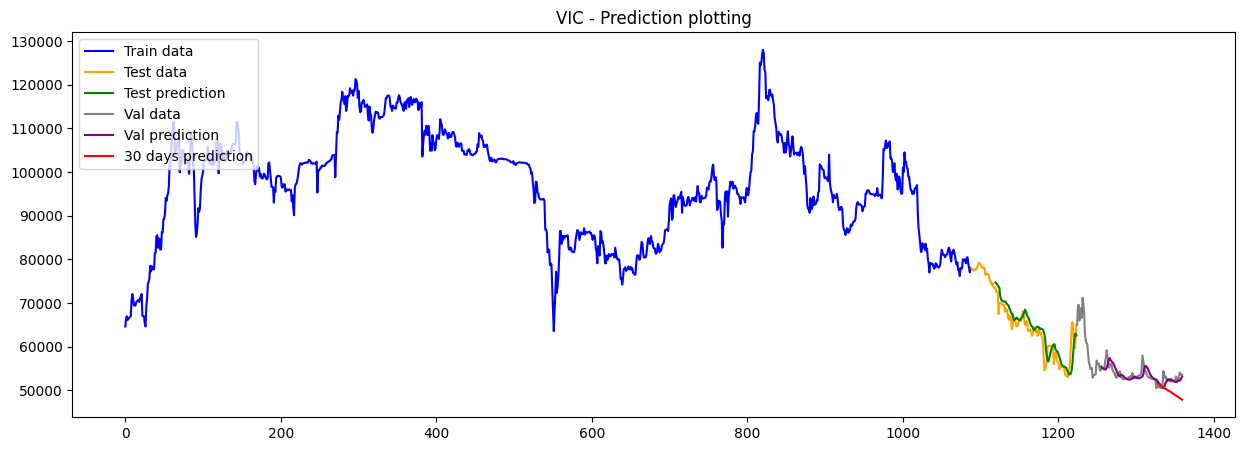

In [141]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('VIC - Prediction plotting')
plt.show()